In [1]:
using GynC, Plots, Distributions

In [ ]:
reload("GynC")

In [169]:
n = 100
mass = 70
mass = 6
tmeas = [1]
measerr = Normal(0,1.5)
ndata = 50
augz = 300
reg = 15/16
augd = 50
smoothsigma = 6

xs = linspace(1,50,n) |> collect

phi(k) = GynC.Federn.odesol(k, tmeas, m=mass)[1]
plot(xs, phi.(xs))

w0 = ones(length(xs)) / length(xs);
prior = GynC.Federn.prior
wprior = pdf(prior, xs)
wprior = wprior / sum(wprior);

srand(3)
m = GynC.syntheticmodel(xs, phi, prior, ndata, augz, measerr)
@show KernelDensity.default_bandwidth(m.datas)
ms = GynC.smoothedmodel(m, 100, m.measerr, sigma=smoothsigma);

KernelDensity.default_bandwidth(m.datas) = 1.4525152051557095


 52.076207 seconds (118.72 k allocations: 1.891 GB, 2.17% gc time)
-126.14866514676483
-16862.53912059626
-5.464769105113683
3.1815916877447457



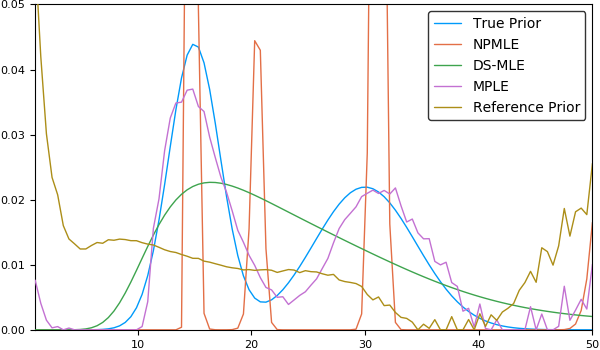

In [170]:
h = 0.1
niter = 1000

wsgrad = Dict()
@time begin
  wsgrad["NPMLE"] = GynC.em(m, w0, niter)
  wsgrad["DS-MLE"] = GynC.em(ms, w0, niter);
  wsgrad["MPLE"]  = GynC.mple(m, w0, niter, reg, h)
  wsgrad["Reference Prior"] = GynC.mple(m, w0, niter, 1, h);
end

ws = wsgrad

GynC.mple_obj(m, 0)(ws["NPMLE"][end]) |> println
GynC.mple_obj(ms, 0)(ws["DS-MLE"][end]) |> println
GynC.mple_obj(m, reg)(ws["MPLE"][end]) |> println
GynC.mple_obj(m, 1)(ws["Reference Prior"][end]) |> println

labels = ["NPMLE" "DS-MLE" "MPLE" "Reference Prior"]
densities = map(l->ws[l][end], labels) |> vec

plot(xs, wprior, label="True Prior", legendfont=font(10), tickfont=font(8), ylims=(0,0.05), size=(600, 350), grid=false)
plot!(xs, densities, labels=labels)

# Plots

In [185]:
kdenpoints = 200
trajts = 0:1/20:5
sols = [GynC.Federn.odesol(k,trajts, m=mass) for k = xs]
#meas = [-9.3]
meas = [phi(21.5)]
trajalpha = 10
priorcolor = :dodgerblue
postcolor  = :orangered
alphalim = 0.001

function bayesposterior(m, data, wprior)
    L = likelihoodmat(m.ys, data, m.measerr)
    GynC.emiteration(wprior, L)
end

function plottrajs(ts, sols, w; alpha=trajalpha, kwargs...)
    as = min.(1., w*alpha)
    i = find(x->x>=alphalim, as)
    plot(ts, sols[i], alpha = as[i]', legend=false, color=:black; kwargs...)
end


function plotcol(w)
    
    yscale = length(xs) / maximum(xs)
    ylims = (0,.20)
    
    pprior = plot(xs, w*yscale, legend=false, color=priorcolor, ylims=ylims)
    
    wpost = bayesposterior(m, meas, w)
    plot!(xs, wpost*yscale, color=postcolor)
    
    
    pprioq = plottrajs(trajts, sols, w)
    scatter!(pprioq, repmat(tmeas, length(m.datas)), m.datas, marker = (:hline, 7, priorcolor, stroke(priorcolor)))
    scatter!(pprioq, repmat(tmeas, length(m.datas)), m.datas, marker = (:vline, 7, priorcolor, stroke(priorcolor)))
    
  
    #ppostq = plottrajdens(trajts, sols, wpost)
    ppostq = plottrajs(trajts, sols, wpost)
    scatter!(ppostq, tmeas, meas, marker = (:hline, 10, postcolor, stroke(postcolor)))
    scatter!(ppostq, tmeas, meas, marker = (:vline, 10, postcolor, stroke(postcolor)))
    [pprior, pprioq, ppostq]
end

#plot(plotcol(ws["NPMLE"])..., size=(1000,400), layout=(1,3))

plotcol (generic function with 1 method)

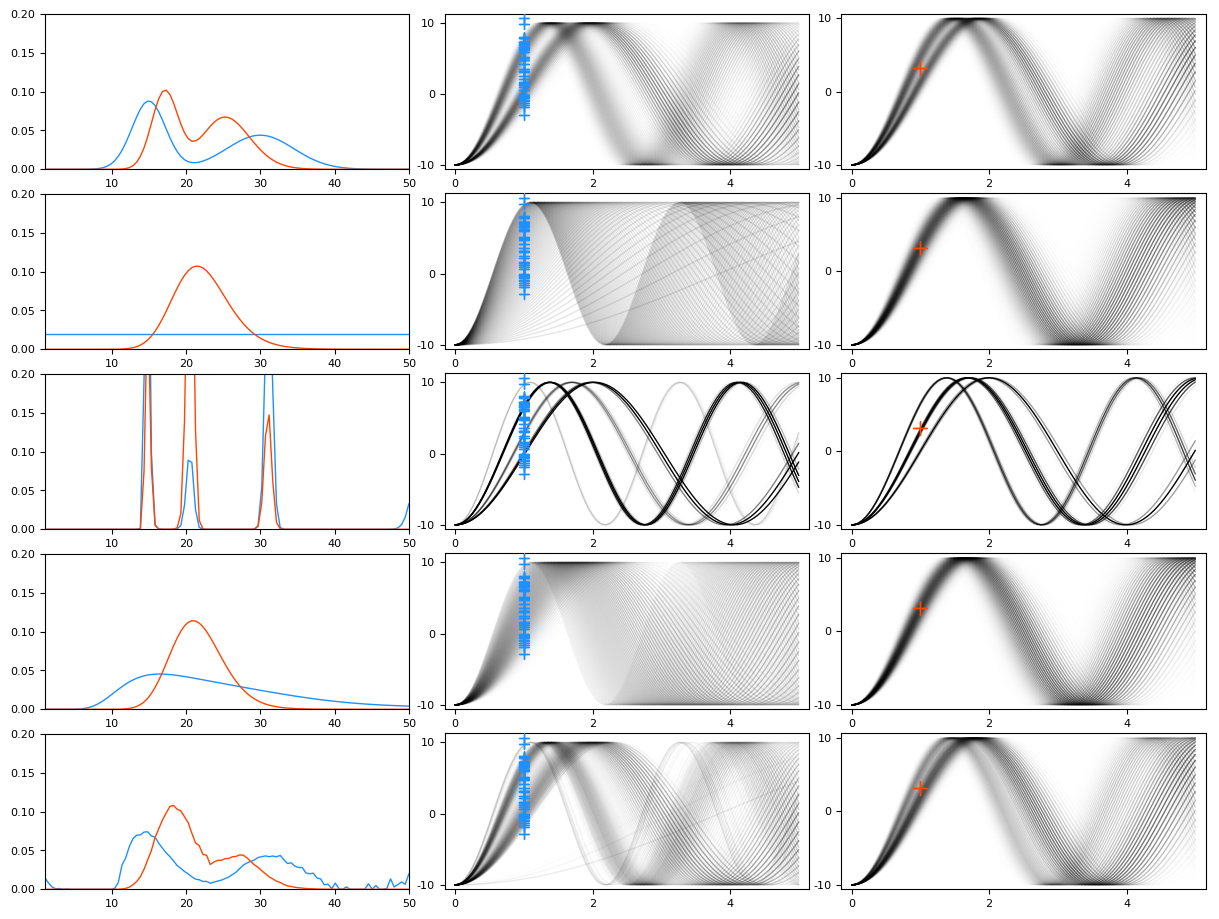

In [279]:
ws = wsgrad

pyplot(fmt=:png, grid=false)
aplots = hcat(plotcol(wprior), plotcol(w0), plotcol(ws["NPMLE"][end]), plotcol(ws["DS-MLE"][end]), plotcol(ws["MPLE"][end]))
plot(aplots..., size=(1200,900), layout=(5,3))
savefig("paperfedern.pdf")

In [280]:
function treatmentdeviations()

  rs = map(m.xs) do x
    maxabs(GynC.Federn.odemittreatment(x, m=6, tspan = linspace(0,30, 400))) > 13 ? 1 : 0
  end
  
  margrate(w, data) = dot(bayesposterior(m, [data], w), rs)
  
  map([wprior, w0, ws["NPMLE"][end], ws["DS-MLE"][end], ws["MPLE"][end]]) do w 
    1/length(m.datas) * sumabs2((margrate(w, data) - margrate(wprior, data) for data in m.datas))
  end
end

treatmentdeviations()

5-element Array{Float64,1}:
 0.0       
 0.0353958 
 0.0662589 
 0.0173655 
 0.00376788